
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves and level

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  
in this notebook:
  * Validation of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)
  


In [270]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.outputs import Plot_LevelVariables_Histograms



## Database and Site parameters

In [271]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)

# Simulation
SIM_C_h = db.Load_SIM_OFFSHORE_all(decode_times=True, use_cftime=True)


In [4]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})


## AWL - Annual Maxima Calculation

In [5]:
# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [6]:
# for a in SIM_C_h.n_sim:
#     s=SIM_C_h.sel(n_sim=a).groupby('time.year').apply(grouped_max, vn='AWL', dim='time')    
#     if a==0:
#         sim_AMax=s
#     else:
#         sim_AMax=xr.concat([sim_AMax,s],dim=['time','n_sim'])
#         sim_AMax['concat_dim']=sim_AMax.n_sim
#         sim_AMax = sim_AMax.drop('n_sim')
#         sim_AMax = sim_AMax.rename({'concat_dim':'n_sim'})
#         sim_AMax


In [7]:
# sim_AMax['concat_dim']=SIM_C_h.n_sim
# sim_AMax = sim_AMax.drop('n_sim')
# sim_AMax = sim_AMax.rename({'concat_dim':'n_sim'})
# sim_AMax

In [8]:
# Simulation AWL Annual Maxima

# calculate AWL annual maxima dataset

sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')      
sim_AMax 

<xarray.Dataset>
Dimensions:     (n_sim: 10, year: 1000)
Coordinates:
  * n_sim       (n_sim) int64 0 1 2 3 4 5 6 7 8 9
    time        (year, n_sim) object 2000-09-04 12:00:00 ... 2999-01-03 00:00:00
  * year        (year) int64 2000 2001 2002 2003 2004 ... 2996 2997 2998 2999
Data variables:
    MJO         (year, n_sim) float64 25.0 18.0 25.0 18.0 ... 25.0 25.0 20.0 9.0
    wind_dir    (year, n_sim) float64 251.0 26.18 92.85 ... 208.1 269.6 35.44
    MMSL        (year, n_sim) float64 0.08468 -0.06876 ... 0.09552 -0.1031
    mslp        (year, n_sim) float64 1.007e+03 1.011e+03 ... 996.7 1.007e+03
    wind_speed  (year, n_sim) float64 6.39 1.838 9.578 ... 7.732 1.396 3.013
    level       (year, n_sim) float64 0.2833 1.315 0.1995 ... -0.1286 -0.1458
    Tp          (year, n_sim) float64 15.55 12.84 12.27 ... 13.24 12.85 13.26
    AT          (year, n_sim) float64 0.1987 0.2067 0.2058 ... -0.2241 -0.04269
    DWT         (year, n_sim) float64 38.0 42.0 21.0 42.0 ... 42.0 21.0 41.0
    AWT         (year, n_sim) float64 5.0 5.0 5.0 5.0 3.0 ... 5.0 1.0 6.0 2.0
    TWL         (year, n_sim) float64 1.403 3.048 1.132 ... 2.338 0.7988 1.236
    AWL         (year, n_sim) float64 1.12 1.733 0.9329 ... 1.797 0.9273 1.382
    max_storms  (year, n_sim) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 1.0
    SS          (year, n_sim) float64 0.0 1.177 0.0 0.9089 ... 0.9487 0.0 0.0
    Hs          (year, n_sim) float64 2.812 9.858 3.13 ... 9.976 2.822 5.886
    Dir         (year, n_sim) float64 64.78 38.56 19.65 ... 21.76 1.228 94.46


## AWL - Annual Maxima Return Period

In [9]:
awl=0.043*(sim_AMax.Hs*1.56*(sim_AMax.Tp/1.25)**2)**(0.5)
awl
twl=0.043*(sim_AMax.Hs*1.56*(sim_AMax.Tp/1.25)**2)**(0.5) + sim_AMax.SS + sim_AMax.AT + sim_AMax.MMSL
twl1=awl + sim_AMax.AT + sim_AMax.MMSL
twl2=np.abs(twl-twl1)
twl2


<xarray.DataArray (year: 1000, n_sim: 10)>
array([[0.        , 1.17714965, 0.        , ..., 0.        , 0.        ,
        1.10149026],
       [0.        , 0.74671149, 0.        , ..., 1.15809655, 1.47177768,
        1.01802468],
       [0.61907947, 0.82194161, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.88337058, 0.53678751, ..., 0.4346959 , 0.5765788 ,
        0.4972533 ],
       [0.        , 0.92520767, 1.24242759, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.48885411, 1.21718299, ..., 0.9486624 , 0.        ,
        0.        ]])
Coordinates:
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
    time     (year, n_sim) object 2000-09-04 12:00:00 ... 2999-01-03 00:00:00
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2995 2996 2997 2998 2999

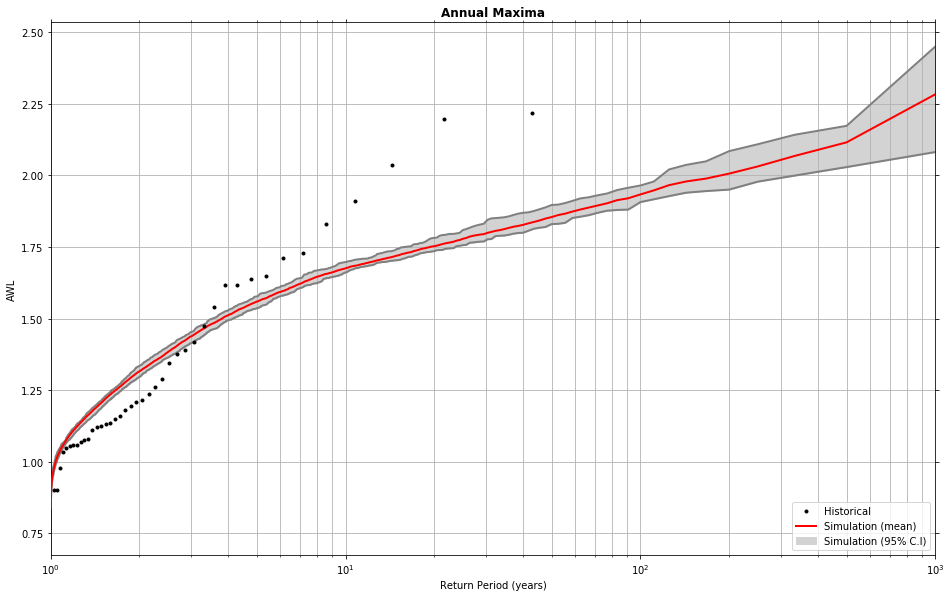

In [10]:
# AWL Annual Maxima Return Period (historical vs. simulations)

Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());


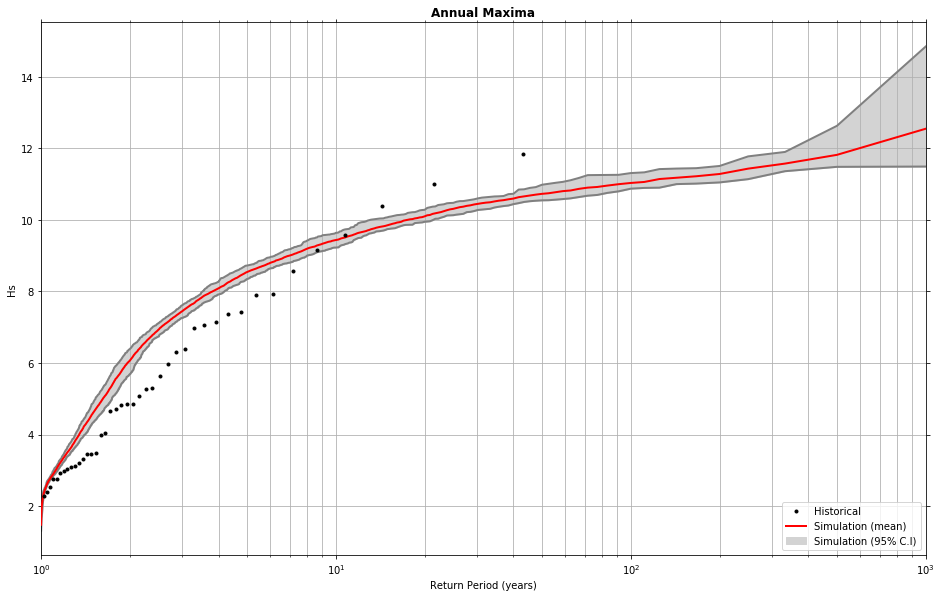

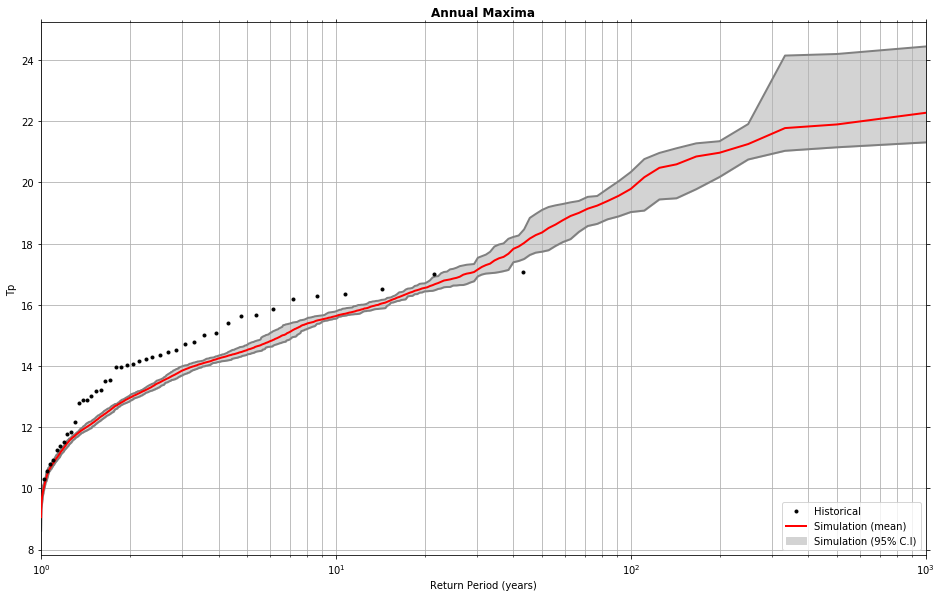

In [11]:
# Hs and Tp Return Period (historical vs. simulations) at AWL Annual Maxima

# Hs at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());

# Tp at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());



## AWL - Annual Maxima Probabilistic Plots

In [12]:
# Probabilistic plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
sim_AMax_n=SIM_C_h.sel(n_sim=n_sim).groupby('time.year').apply(grouped_max, vn='AWL', dim='time')    
# sim_AMax_n = sim_AMax.sel(n_sim=0)


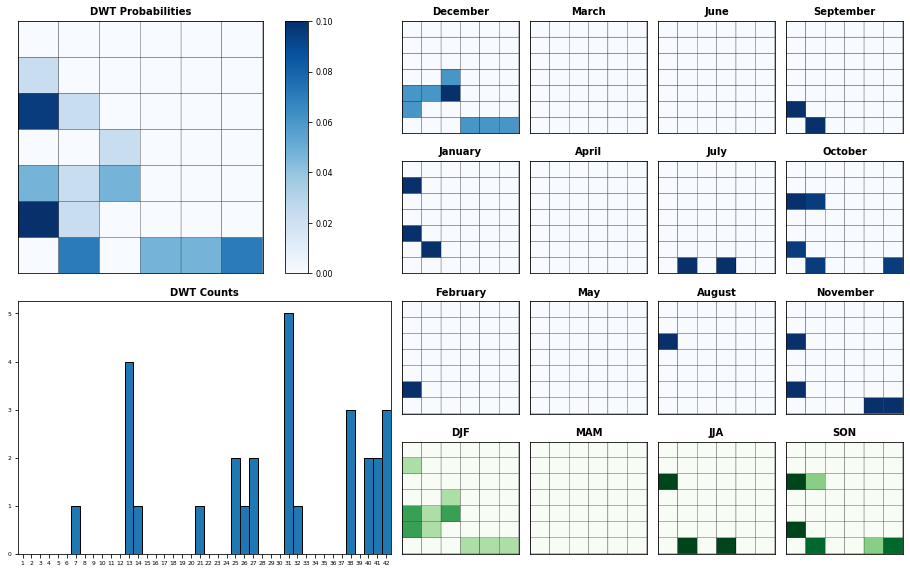

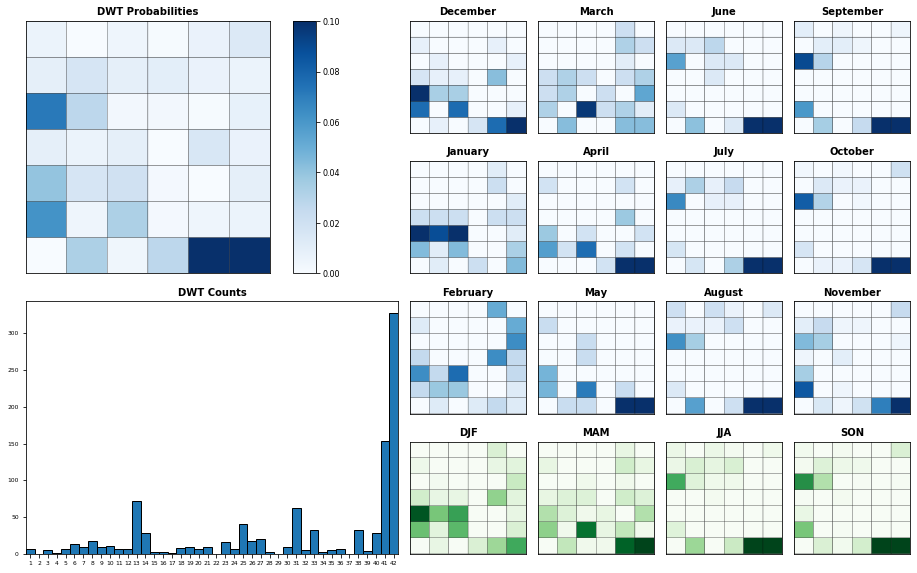

In [13]:
# Plot Annual Maxima DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_AMax['DWT'].values, hist_AMax.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_AMax_n['DWT'].values, sim_AMax_n.time.values, n_clusters_DWT);


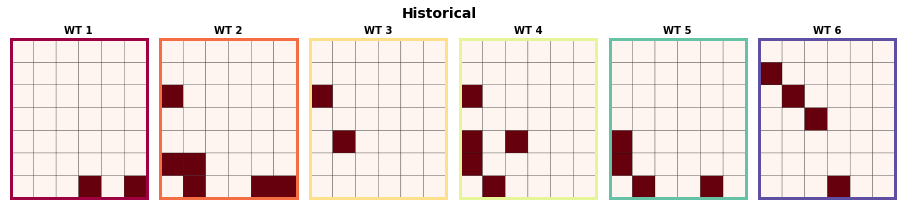

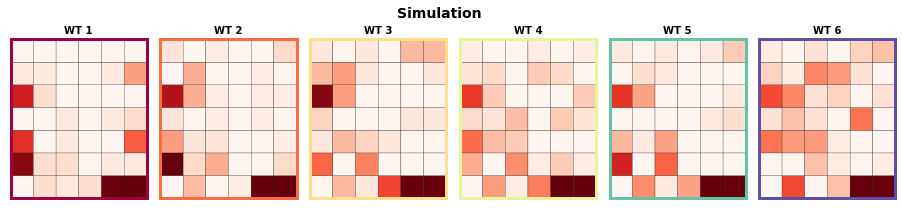

In [14]:
# Plot Annual Maxima AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_AMax['AWT'].values - 1, hist_AMax['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_AMax_n['AWT'].values[:] - 1, sim_AMax_n['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## AWL - Peaks Over Threshold Calculation

In [15]:
# POT  plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
SIM_C_h_n = SIM_C_h.sel(n_sim=0)


# TODO: update POT to work with hourly data
_, ix = np.unique(SIM_C_h_n['time'], return_index=True)  
SIM_C_h_n = SIM_C_h_n.isel(time=ix)

# Parse data to daily 
HIST_C_d = xds_reindex_daily(HIST_C_nonan)  # TODO: check possible bug if this puts NAN inside AWL data
SIM_C_d_n = xds_reindex_daily(SIM_C_h_n)


In [16]:
# Get independent event peaks (99 percentile)

# Historical
times_POT = POT(HIST_C_d.isel(time=slice(1,-1)), 'AWL', 95).time  # TODO: check possible awl nan bug
hist_POT = HIST_C_d.sel(time = times_POT)

# Simulation
times_POT = POT(SIM_C_d_n, 'AWL', 95).time
sim_POT = SIM_C_d_n.sel(time = times_POT)



## AWL - Peaks Over Threshold Probabilistic Plots

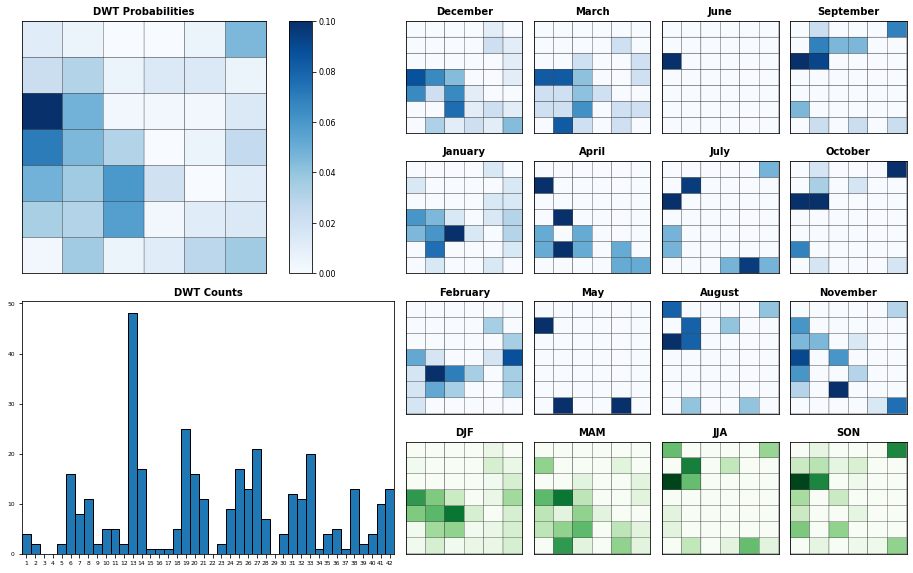

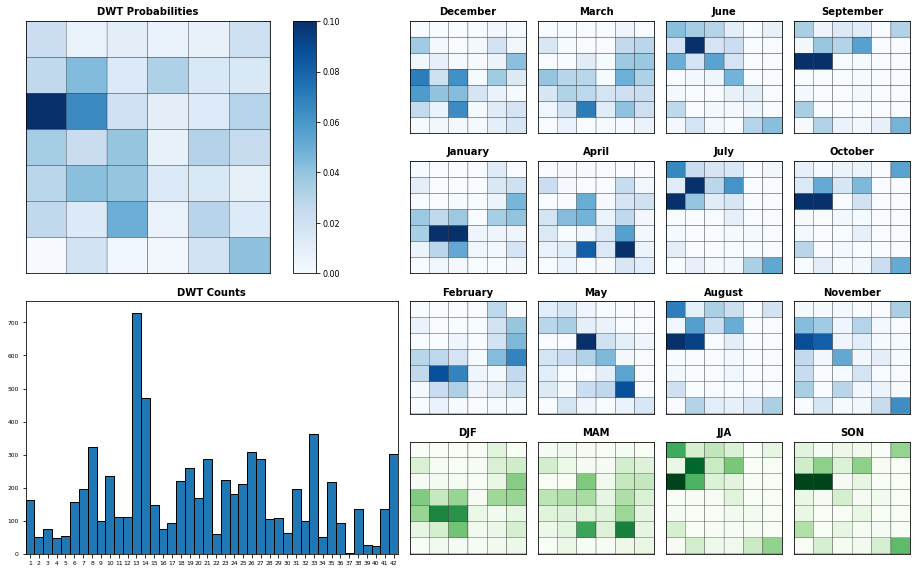

In [17]:
# Plot Peaks Over Threshold DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_POT['DWT'].values, hist_POT.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_POT['DWT'].values, sim_POT.time.values, n_clusters_DWT);


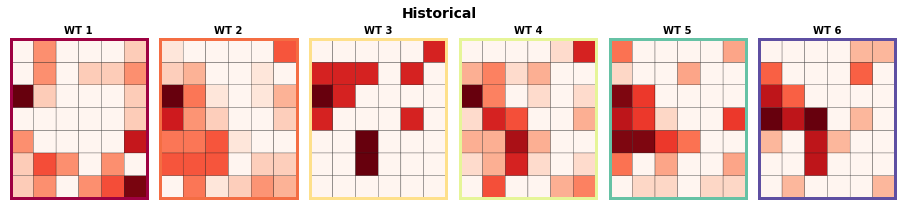

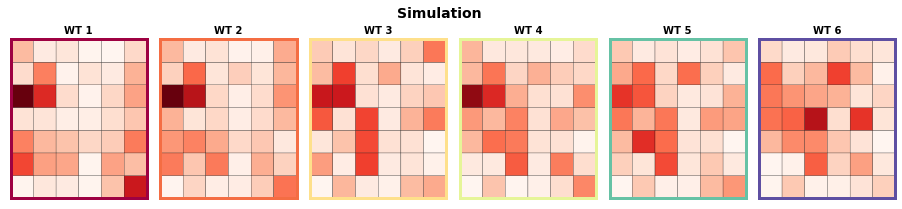

In [18]:
# Plot Peaks Over Threshold AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_POT['AWT'].values - 1, hist_POT['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_POT['AWT'].values[:] - 1, sim_POT['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## Level Variables (level, AT, MMSL, TWL) - Histograms

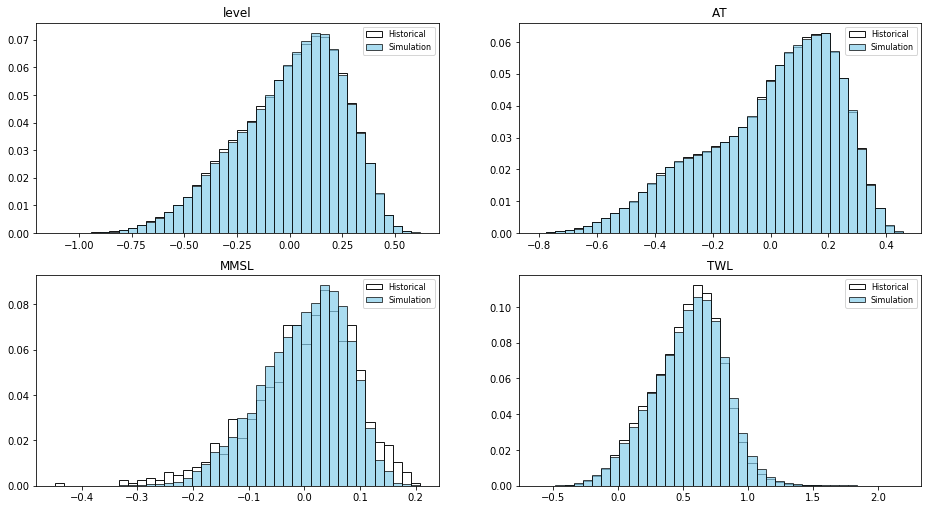

In [19]:

# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_LevelVariables_Histograms(HIST_C_h, SIM_C_h.sel(n_sim = 0));



## TWL - Annual Maxima

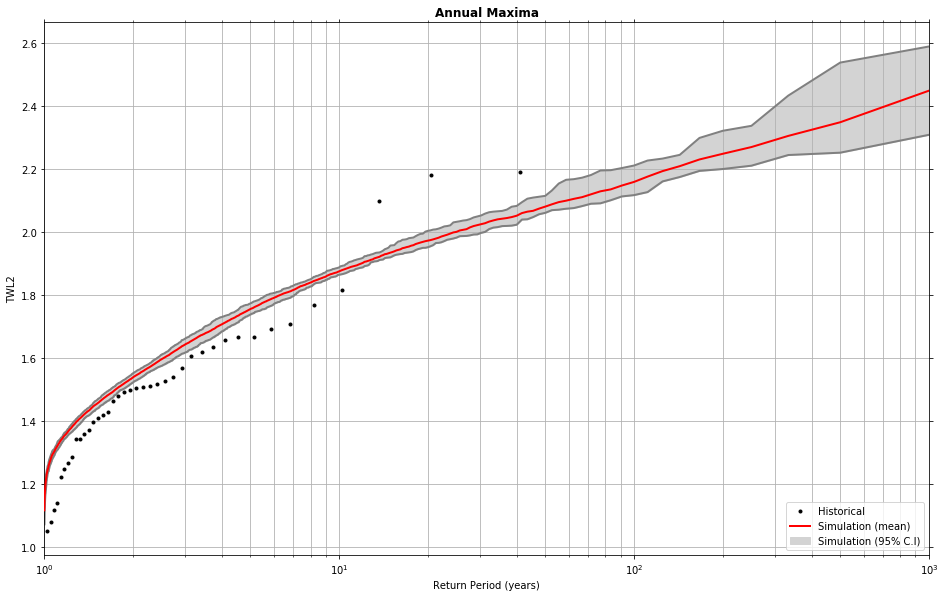

In [20]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data
# Removing storm surge from simulations
HIST_C_h['TWL2']=0.043*(HIST_C_h.Hs*1.56*(HIST_C_h.Tp/1.25)**2)**(0.5) + HIST_C_h.AT + HIST_C_h.MMSL
SIM_C_h['TWL2']=0.043*(SIM_C_h.Hs*1.56*(SIM_C_h.Tp/1.25)**2)**(0.5) + SIM_C_h.AT + SIM_C_h.MMSL

hist_A = HIST_C_h['TWL2'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL2'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());


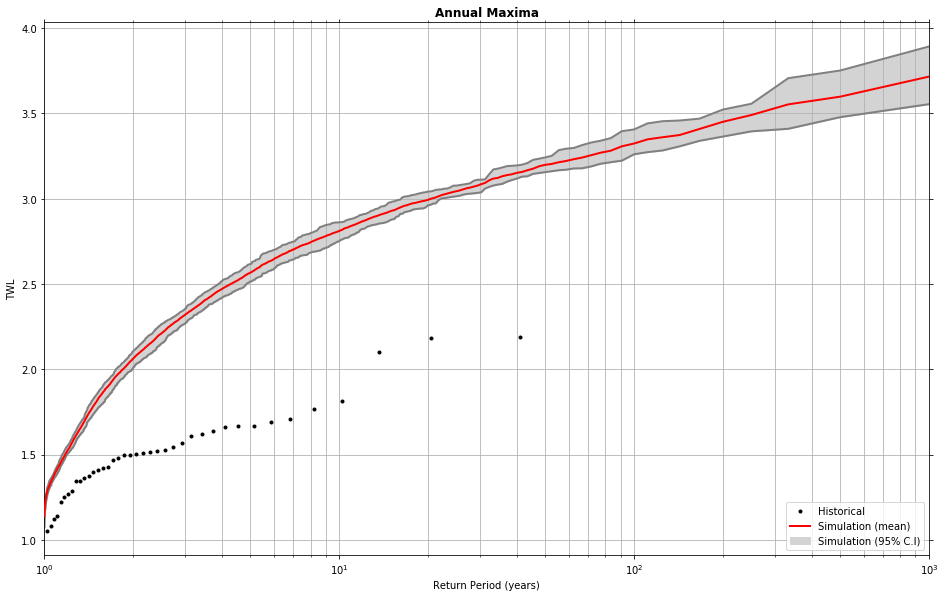

In [21]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data

hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());


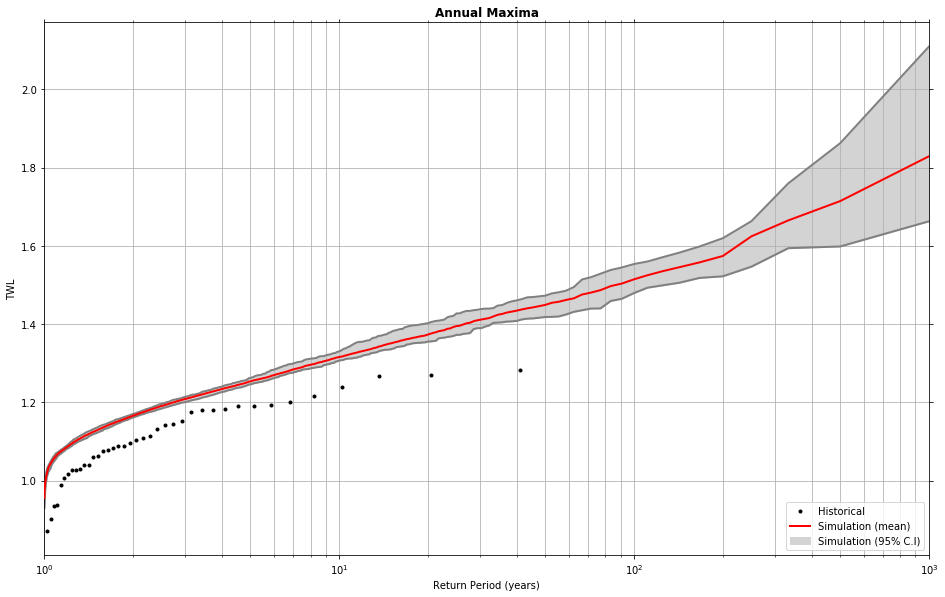

In [23]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').quantile(0.99,dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').quantile(0.99,dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());

### CORRECT HISTORICAL STORM SURGE WITH INVERSE BAROMETER

In [272]:
 # --------------------------------------
# Sea Level Pressure for obtain level due to Inverse Barometer (IB)
SLP = db.Load_ESTELA_SLP()   # Sea Level Pressure from CFSR (Pa)

# --------------------------------------
# Storm Surge from Inverse Barometer 

#Guam pnt_lon = 144.75, pnt_lat = 13.44
lonp = 144 # closest coordinates in SLP dataset
latp = 14

# select closest grid point to Site
SLP_p = SLP.sel(longitude = lonp, latitude = latp) 

# Calculate anomalies and change units 
SLP_p['SLP'] = SLP_p.SLP*0.01 # (Pa to mb)
SLP_p['SLP_anomaly'] = SLP_p.SLP - np.mean(SLP_p.SLP.values)

SLP_p['level_IB'] = -1*SLP_p.SLP_anomaly # (Inverse Barometer: mb to cm)
SLP_p['level_IB'] = SLP_p.level_IB/100.0 # (cm to m)

SLP_p['time'] = SLP_p['time'].dt.round('H')

print(SLP_p)

<xarray.Dataset>
Dimensions:      (time: 359401)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    longitude    float32 144.0
    latitude     float32 14.0
Data variables:
    SLP          (time) float64 1.011e+03 1.011e+03 ... 1.016e+03 1.016e+03
    SLP_anomaly  (time) float64 0.2311 0.304 0.02209 ... 5.292 5.517 5.485
    level_IB     (time) float64 -0.002311 -0.00304 ... -0.05517 -0.05485


In [34]:
SLP_p.to_netcdf(path='/media/administrador/HD/Dropbox/Guam/teslakit/data/sites/GUAM/HISTORICAL/OFFSHORE/Inverse_barometer.nc')

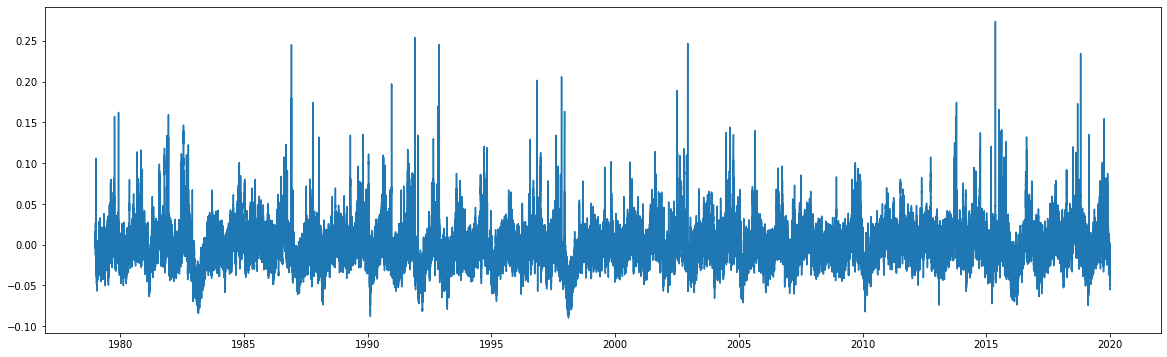

In [29]:
plt.figure(figsize=[20,6])
plt.plot(SLP_p.time,SLP_p['level_IB'])

In [32]:
print( HIST_C_h['TWL'])
print()
print(SLP_p['level_IB'])


# Add historical surge to TWL
HIST_C_h['TWL'] = HIST_C_h['TWL'] + SLP_p['level_IB']

<xarray.DataArray 'TWL' (time: 1229425)>
[1229425 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1880-06-01 1880-06-01T01:00:00 ... 2020-09-01
Attributes:
    units:       meters
    short_name:  twl
    long_name:   total water level

<xarray.DataArray 'level_IB' (time: 359401)>
array([-0.00231077, -0.00304046, -0.00022093, ..., -0.05291702,
       -0.05516702, -0.05484749])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    longitude  float32 144.0
    latitude   float32 14.0


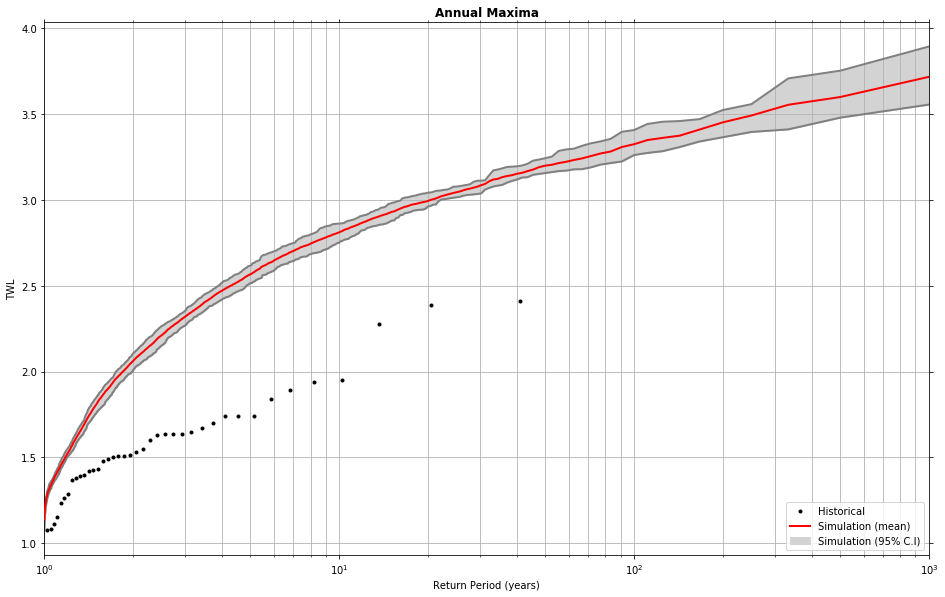

In [33]:
# Plot TWL annual maxima with Storm Surge

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());

In [46]:
SIM_C_h

<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 8765832)
Coordinates:
  * time        (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * n_sim       (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MJO         (time, n_sim) float64 ...
    wind_dir    (time, n_sim) float64 ...
    MMSL        (time, n_sim) float64 ...
    mslp        (time, n_sim) float64 ...
    wind_speed  (time, n_sim) float64 ...
    level       (time, n_sim) float64 ...
    Tp          (time, n_sim) float64 ...
    AT          (time, n_sim) float64 ...
    DWT         (time, n_sim) float64 ...
    AWT         (time, n_sim) float64 ...
    TWL         (time, n_sim) float64 ...
    AWL         (time, n_sim) float64 ...
    max_storms  (time, n_sim) float64 ...
    SS          (time, n_sim) float64 ...
    Hs          (time, n_sim) float64 ...
    Dir         (time, n_sim) float64 ...
    TWL2        (time, n_sim) float64 0.2625 0.3891 0.2249 ... 0.7171 0.5906

In [48]:
# Plot TWL - AWL (LEVEL)

SS_HIST=(SLP_p['level_IB']).groupby('time.year').max(dim='time')
SS_SIM=(SIM_C_h['SS']).groupby('time.year').max(dim='time')

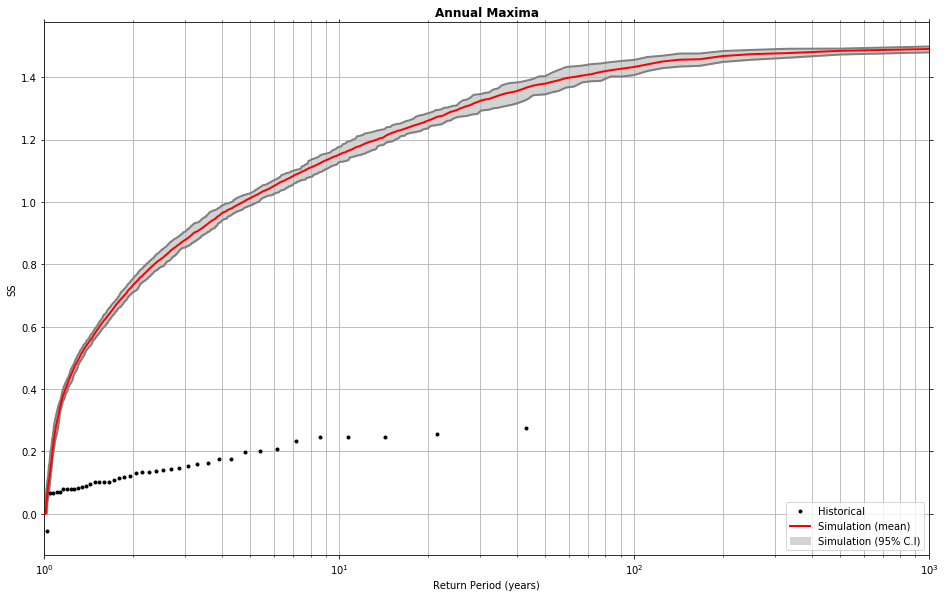

In [49]:
# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(SS_HIST, SS_SIM.transpose());

## CORRECT TCs WITH IBTRACS

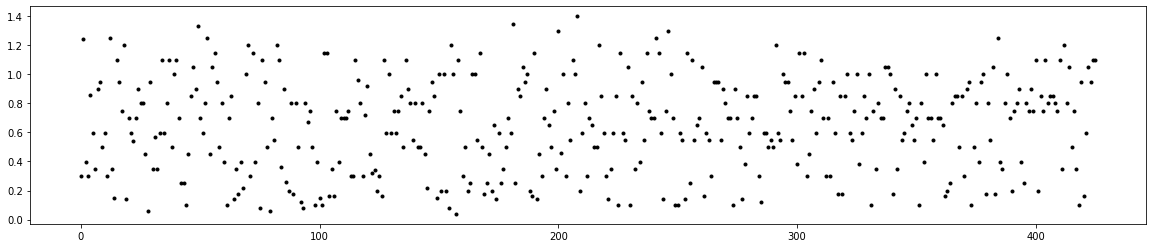

In [273]:
TCs_r2, TCs_r2_params = db.Load_TCs_r2_hist()  # TCs parameters inside radius 2
press=np.nanmin(TCs_r2.wmo_pres,axis=1)
press


Text(0, 0.5, 'SS (m)')

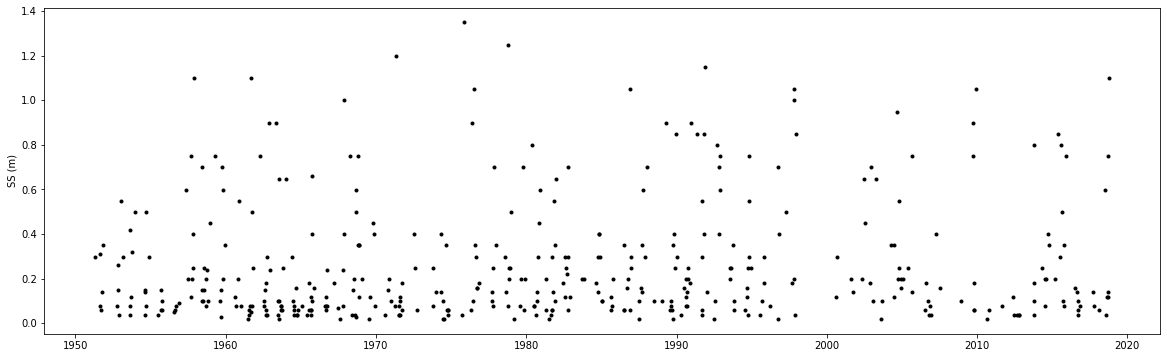

In [274]:
p=[]
for a in range(len(TCs_r2.storm)):
    t=TCs_r2.time.values[a,:]
    pm=TCs_r2_params.pressure_min.values[a]
    p.append(pm)
    s=np.where(TCs_r2.wmo_pres.values[a,:]==pm)
    if a==0:
        time_pm=TCs_r2.time.values[a,s[0]]
    else:
        time_pm=np.append(time_pm,TCs_r2.time.values[a,s[0][0]])
        
ss_storm = np.array(p) - 1009.915
ss_storm = -1*ss_storm  # (Inverse Barometer: mb to cm)
SS_TCs= ss_storm/100.0 # (cm to m)

plt.figure(figsize=[20,6])
plt.plot(time_pm,SS_TCs,'k.')
plt.ylabel('SS (m)')

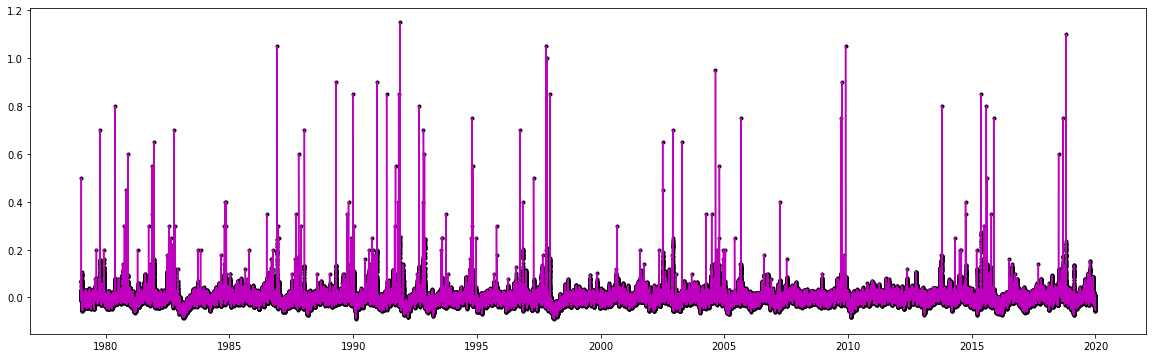

In [275]:
ss_corrected=SLP_p.level_IB.values
for a in range(len(time_pm)):
    
    s=np.where(SLP_p.time.dt.floor('h')==time_pm[a])[0]
    ss_corrected[s]=SS_TCs[a]

plt.figure(figsize=[20,6])
plt.plot(SLP_p.time,SLP_p['level_IB'],'k.')
plt.plot(SLP_p.time,ss_corrected,'m')

SLP_p['corrected_SS']=('time',ss_corrected)

In [280]:
SLP_p.to_netcdf(path='/media/administrador/HD/Dropbox/Guam/teslakit/data/sites/GUAM/HISTORICAL/OFFSHORE/Corrected_SS_Ibtracs.nc')

In [246]:
# Plot TWL - AWL (LEVEL)

SS_HIST=(SLP_p['corrected_SS']).groupby('time.year').max(dim='time')
SS_SIM=(SIM_C_h['SS']).groupby('time.year').max(dim='time')

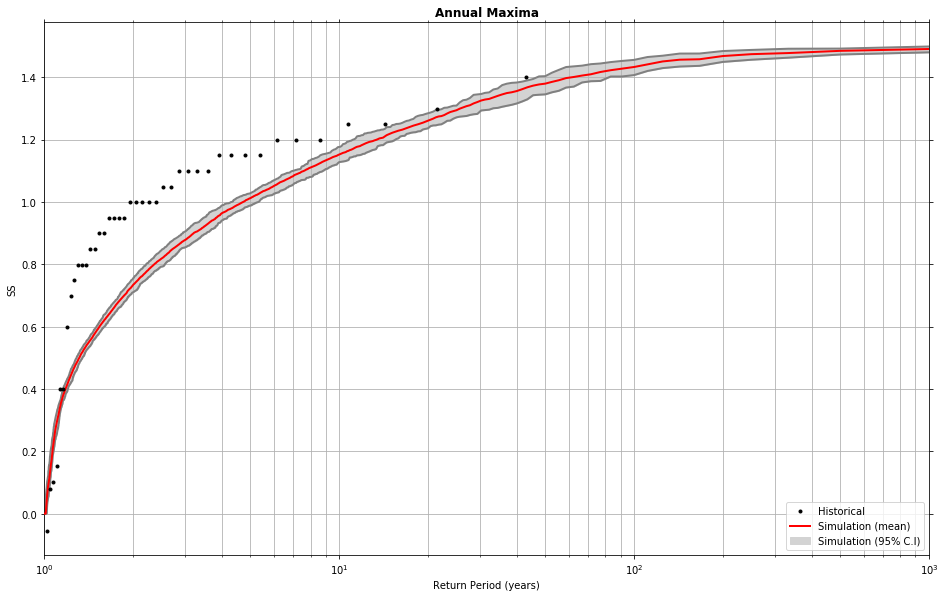

In [247]:
# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(SS_HIST, SS_SIM.transpose());

In [255]:
# Add historical surge to TWL
HIST_C_h['TWL'] = HIST_C_h['AWL']+HIST_C_h['AT'] +HIST_C_h['MMSL'] + SLP_p['corrected_SS']

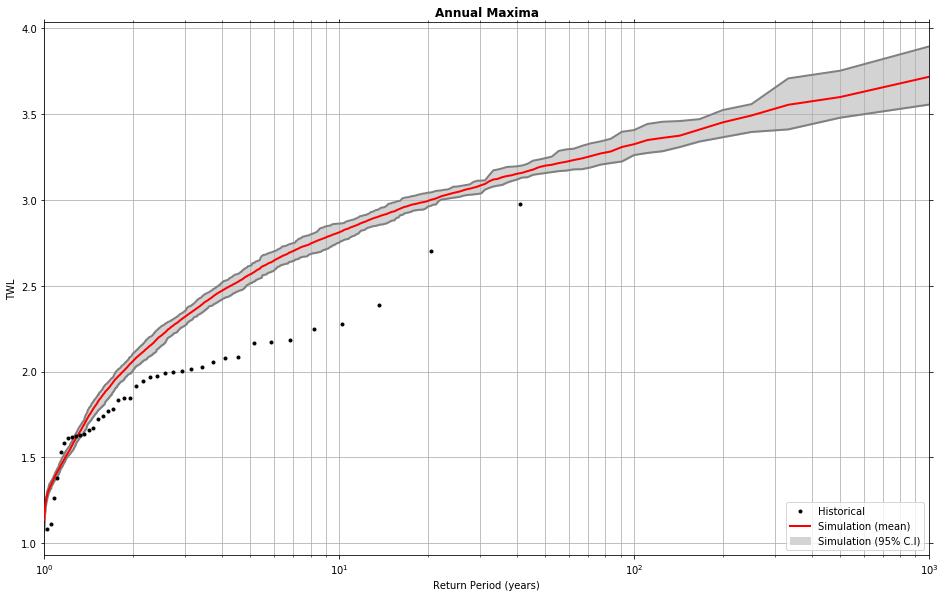

In [256]:
# Plot TWL annual maxima with Storm Surge

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());

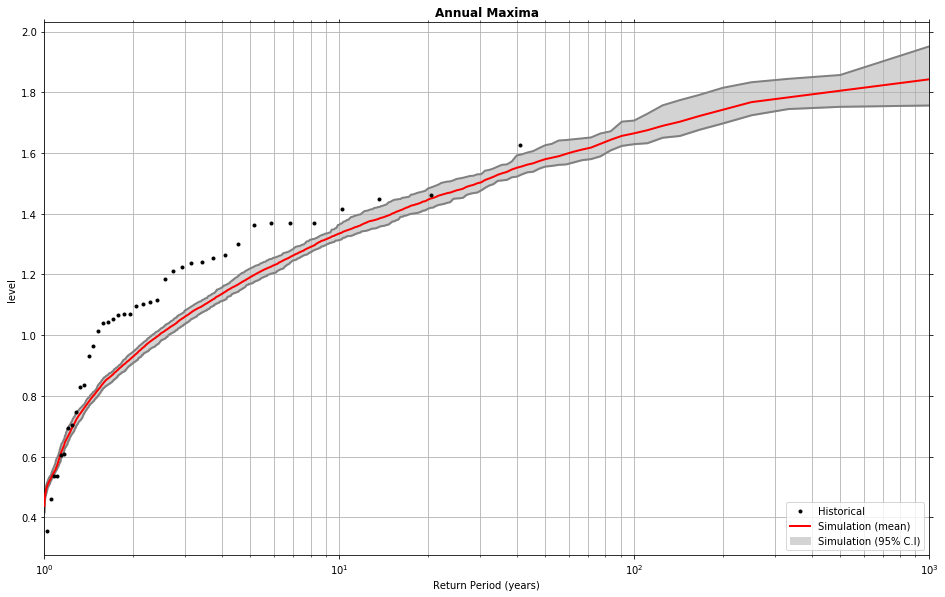

In [261]:
# Plot TWL annual maxima with Storm Surge

HIST_C_h['level']=HIST_C_h['AT'] +HIST_C_h['MMSL'] + SLP_p['corrected_SS']

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['level'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['level'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());